In [79]:
import importlib
import warnings
import common_func as cf
import asyncio
importlib.reload(cf)
warnings.filterwarnings('ignore')

In [80]:
class ShortStrangle(cf.TradingStrategy):
    def __init__(self, loader: cf.DataLoader, asset_name):
        cf.TradingStrategy.__init__(self, loader, asset_name, 2)

    def _get_option_count(self):
        return 2

    def _get_strategy_delta(self, calls:list, puts: list) -> float:
        return calls[1]['Delta'] + puts[1]['Delta']

    def _is_strategy_valid(self, calls:list, puts: list) -> bool:
        return calls[1]['Strike'] > puts[1]['Strike']

    def _short_portfolio(self, calls:list, puts: list):
        return [calls[1], puts[1]]

    def _long_portfolio(self, calls:list, puts: list):
        return []

class ShortStrangle2(cf.TradingStrategy):
    def __init__(self, loader: cf.DataLoader, asset_name):
        cf.TradingStrategy.__init__(self, loader, asset_name, 2)

    def _get_option_count(self):
        return 2

    def _get_strategy_delta(self, calls:list, puts: list) -> float:
        return calls[0]['Delta'] + puts[1]['Delta']

    def _is_strategy_valid(self, calls:list, puts: list) -> bool:
        return calls[0]['Strike'] > puts[1]['Strike']

    def _short_portfolio(self, calls:list, puts: list):
        return [calls[0], puts[1]]

    def _long_portfolio(self, calls:list, puts: list):
        return []

class ShortStrangle3(cf.TradingStrategy):
    def __init__(self, loader: cf.DataLoader, asset_name):
        cf.TradingStrategy.__init__(self, loader, asset_name, 3)

    def _get_option_count(self):
        return 2

    def _get_strategy_delta(self, calls:list, puts: list) -> float:
        return calls[0]['Delta'] + puts[2]['Delta']

    def _is_strategy_valid(self, calls:list, puts: list) -> bool:
        return calls[0]['Strike'] > puts[2]['Strike']

    def _short_portfolio(self, calls:list, puts: list):
        return [calls[0], puts[2]]

    def _long_portfolio(self, calls:list, puts: list):
        return []

class ShortStraddle(cf.TradingStrategy):
    def __init__(self, loader: cf.DataLoader, asset_name):
        cf.TradingStrategy.__init__(self, loader, asset_name, 1)

    def _get_option_count(self):
        return 2

    def _get_strategy_delta(self, calls:list, puts: list) -> float:
        return calls[0]['Delta'] + puts[0]['Delta']

    def _is_strategy_valid(self, calls:list, puts: list) -> bool:
        return calls[0]['Strike'] == puts[0]['Strike']

    def _short_portfolio(self, calls:list, puts: list):
        return [calls[0], puts[0]]

    def _long_portfolio(self, calls:list, puts: list):
        return []



All files for AMZN are ready. Loading
End loading in 0.375 seconds
Simple simulation for AMZN
Short strangle


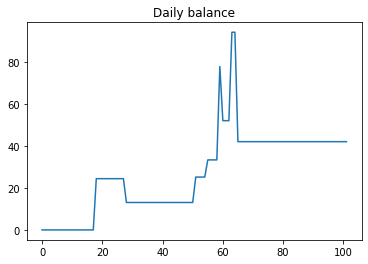

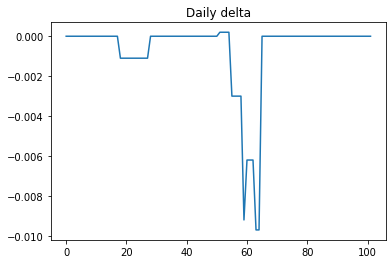

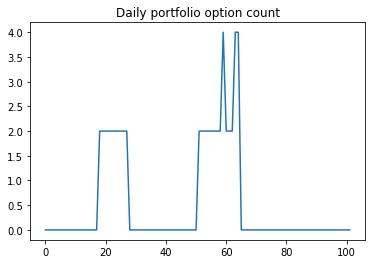

Elapsed time 2.8125 seconds
Short strangle2


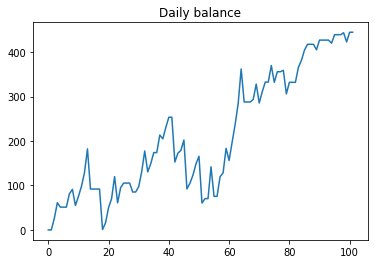

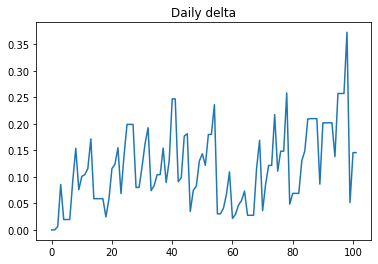

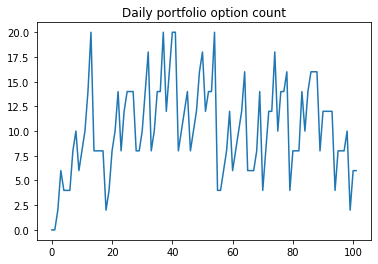

Elapsed time 2.984375 seconds
Short strangle3


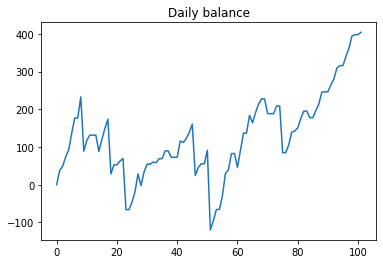

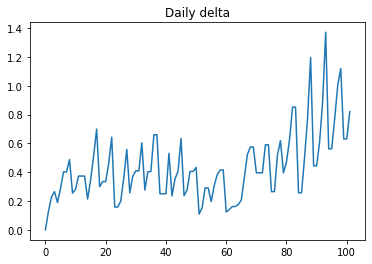

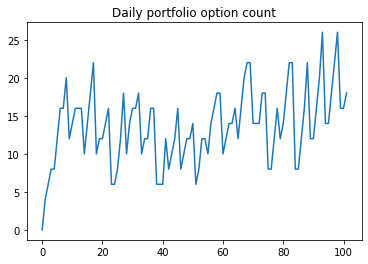

Elapsed time 4.4375 seconds
Short straddle


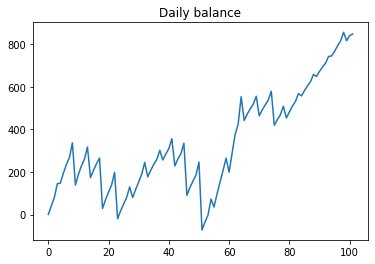

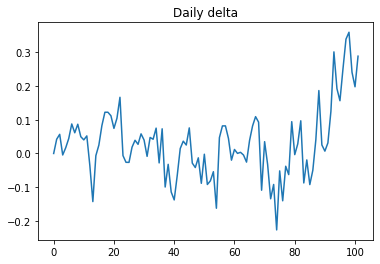

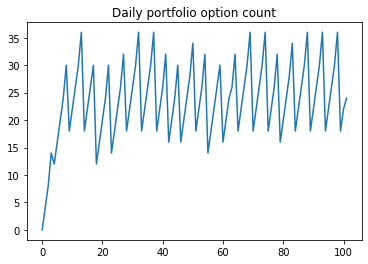

Elapsed time 1.671875 seconds
Start loading
End loading in 15.703125 seconds
Start grouping
Grouping processed in 24.640625 seconds
Start grouping
Grouping processed in 22.0 seconds
Start grouping
Grouping processed in 22.265625 seconds
Start grouping
Grouping processed in 26.515625 seconds
Start grouping
Grouping processed in 23.65625 seconds
Start grouping
Grouping processed in 22.984375 seconds
Simple simulation for GOOGL
Short strangle


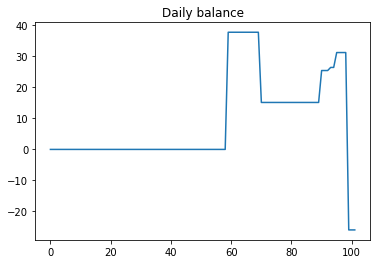

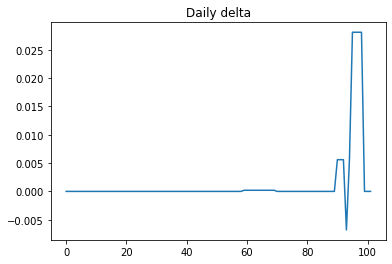

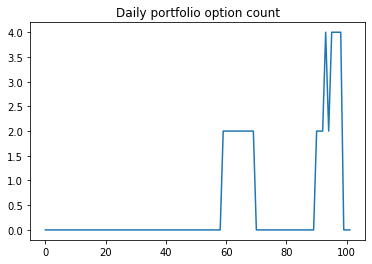

Elapsed time 4.25 seconds
Short strangle2


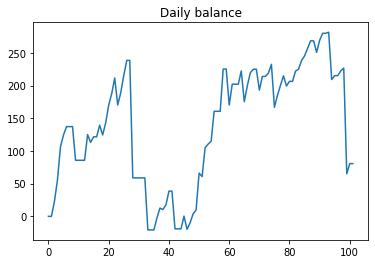

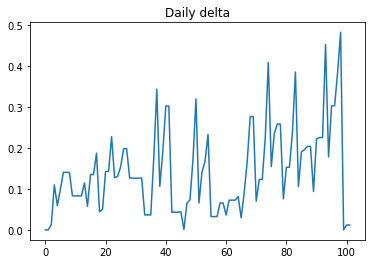

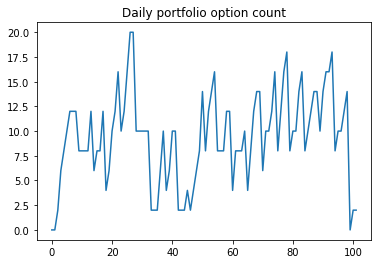

Elapsed time 3.203125 seconds
Short strangle3


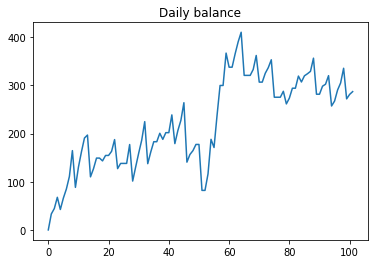

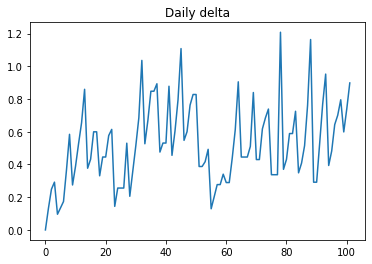

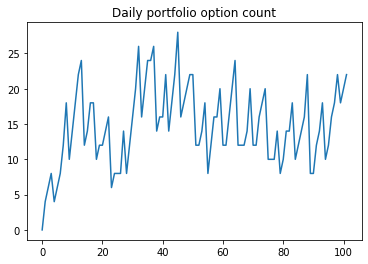

Elapsed time 4.703125 seconds
Short straddle


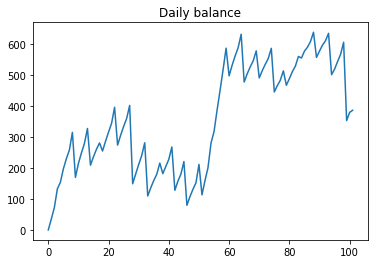

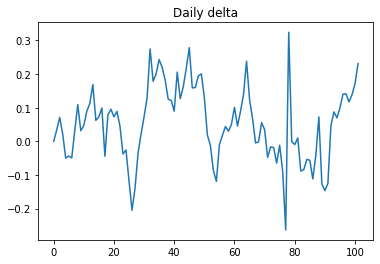

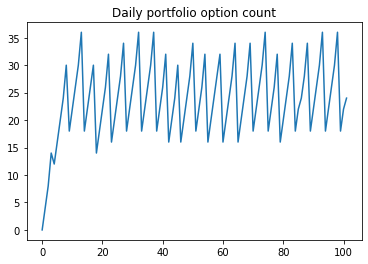

Elapsed time 1.71875 seconds
Start loading
End loading in 7.328125 seconds
Start grouping
Grouping processed in 21.15625 seconds
Start grouping
Grouping processed in 21.234375 seconds
Start grouping
Grouping processed in 23.5625 seconds
Start grouping
Grouping processed in 21.703125 seconds
Start grouping
Grouping processed in 23.765625 seconds
Start grouping
Grouping processed in 23.703125 seconds
Simple simulation for NFLX
Short strangle


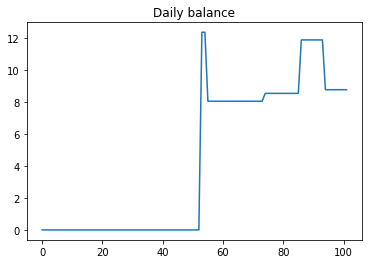

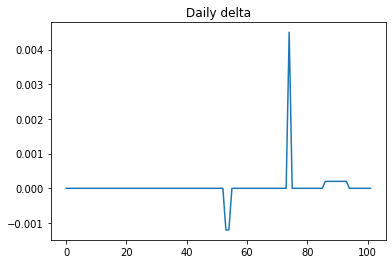

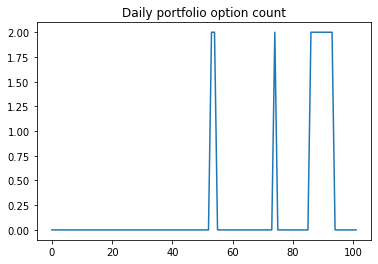

Elapsed time 4.3125 seconds
Short strangle2


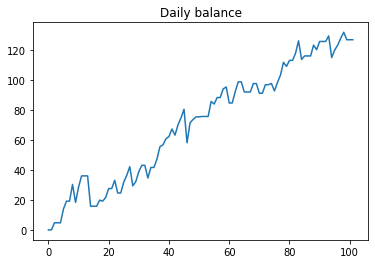

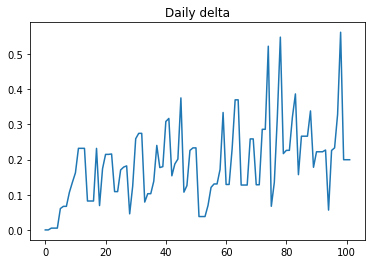

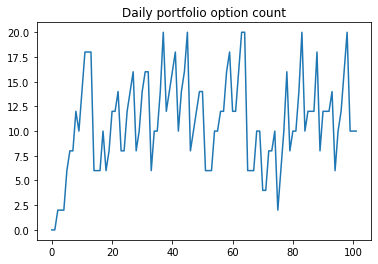

Elapsed time 3.078125 seconds
Short strangle3


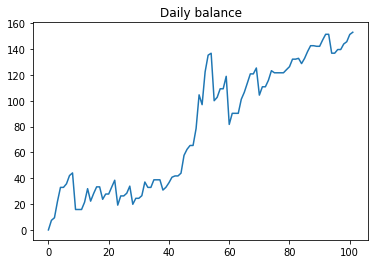

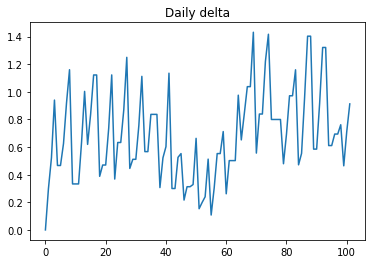

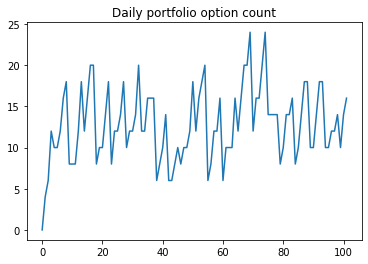

Elapsed time 4.5625 seconds
Short straddle


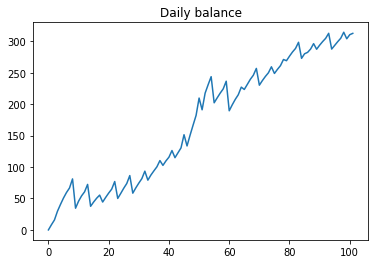

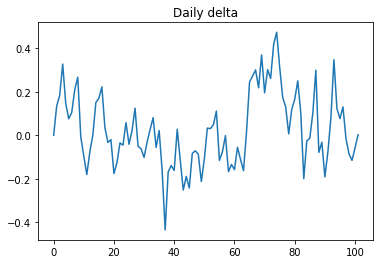

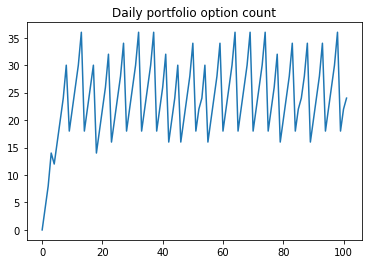

Elapsed time 1.75 seconds
Start loading
End loading in 4.34375 seconds
Start grouping
Grouping processed in 26.34375 seconds
Start grouping
Grouping processed in 27.234375 seconds
Start grouping
Grouping processed in 24.453125 seconds
Start grouping
Grouping processed in 24.453125 seconds
Start grouping
Grouping processed in 25.703125 seconds
Start grouping
Grouping processed in 26.5 seconds
Simple simulation for MSFT
Short strangle


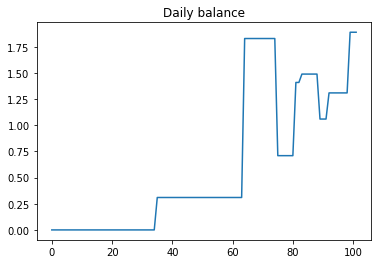

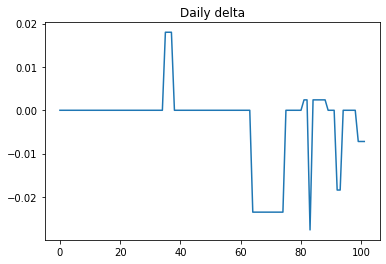

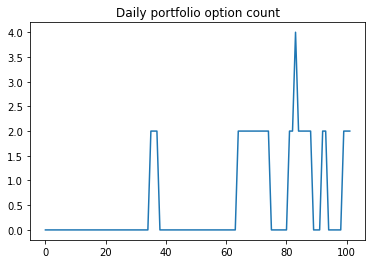

Elapsed time 3.875 seconds
Short strangle2


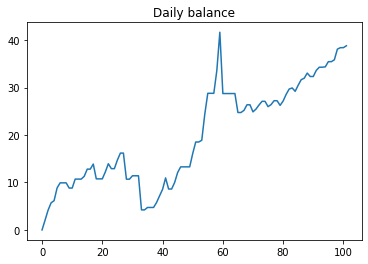

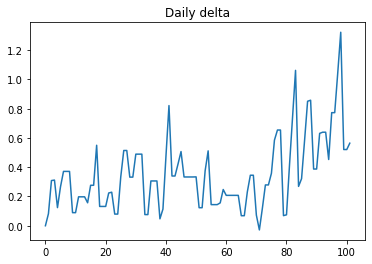

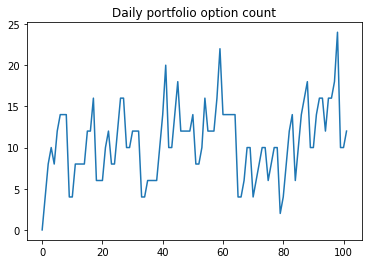

Elapsed time 3.734375 seconds
Short strangle3


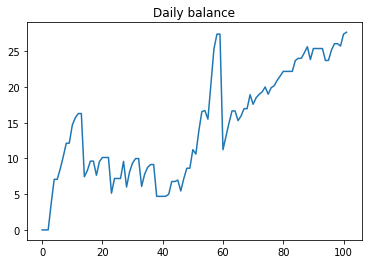

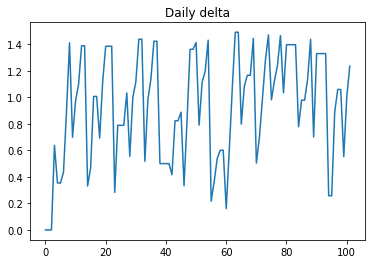

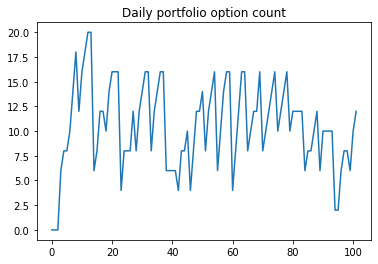

Elapsed time 5.46875 seconds
Short straddle


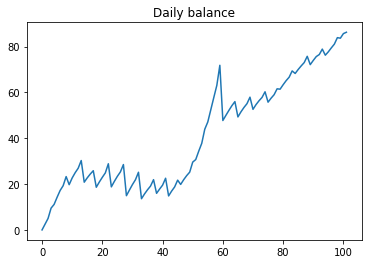

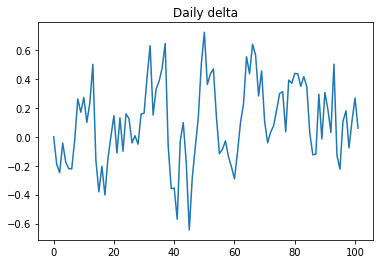

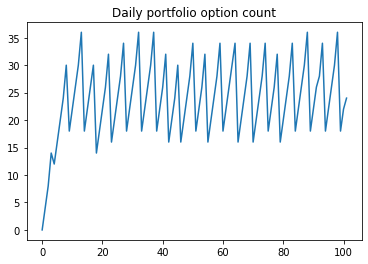

Elapsed time 1.890625 seconds
Start loading
End loading in 5.03125 seconds
Start grouping
Grouping processed in 23.125 seconds
Start grouping
Grouping processed in 22.9375 seconds
Start grouping
Grouping processed in 25.125 seconds
Start grouping
Grouping processed in 23.9375 seconds
Start grouping
Grouping processed in 24.921875 seconds
Start grouping
Grouping processed in 22.71875 seconds
Simple simulation for FB
Short strangle


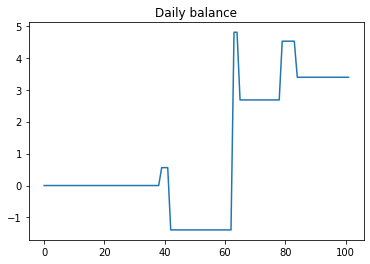

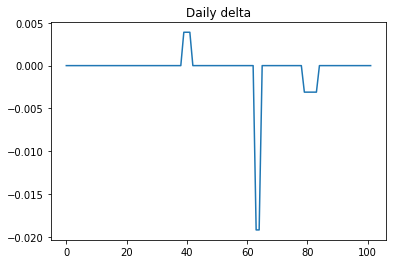

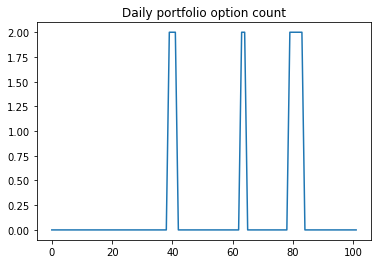

Elapsed time 3.46875 seconds
Short strangle2


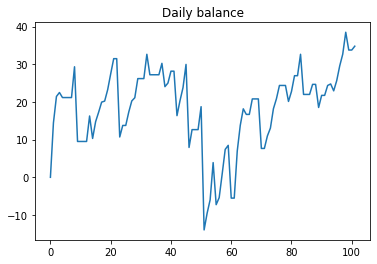

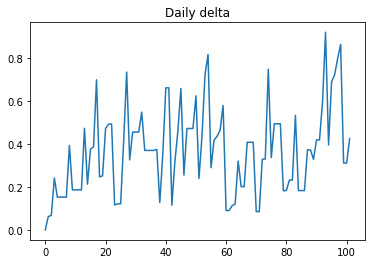

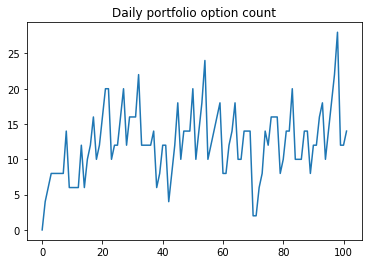

Elapsed time 3.203125 seconds
Short strangle3


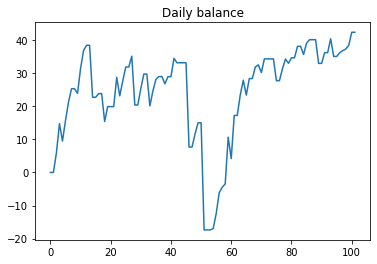

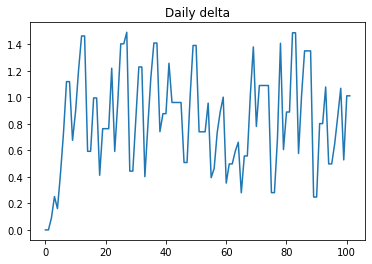

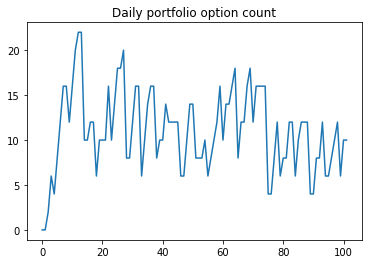

Elapsed time 4.65625 seconds
Short straddle


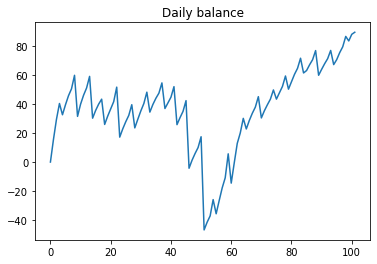

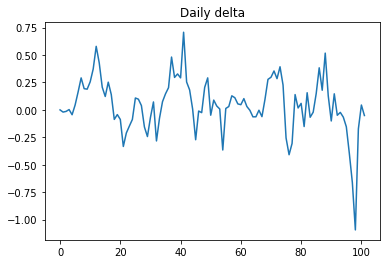

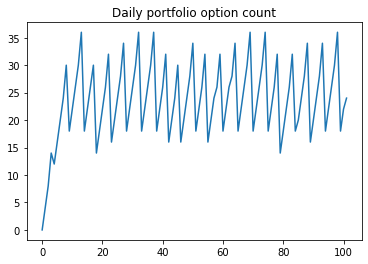

Elapsed time 1.765625 seconds
Start loading
End loading in 4.890625 seconds
Start grouping
Grouping processed in 20.953125 seconds
Start grouping
Grouping processed in 21.296875 seconds
Start grouping
Grouping processed in 21.90625 seconds
Start grouping
Grouping processed in 23.40625 seconds
Start grouping
Grouping processed in 26.703125 seconds
Start grouping
Grouping processed in 30.078125 seconds
Simple simulation for BA
Short strangle


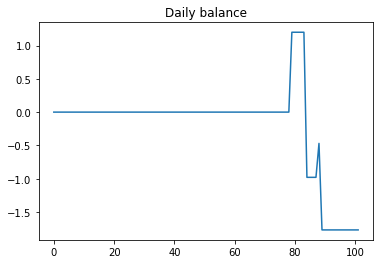

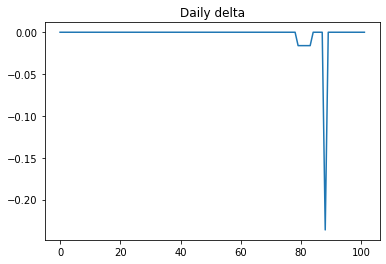

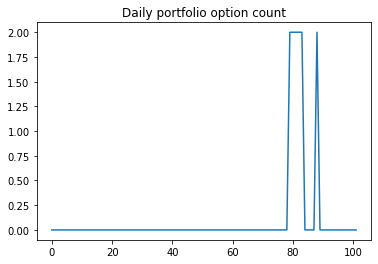

Elapsed time 3.3125 seconds
Short strangle2


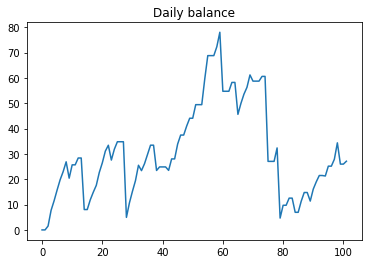

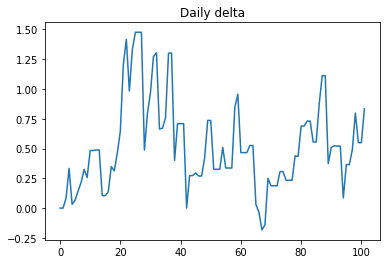

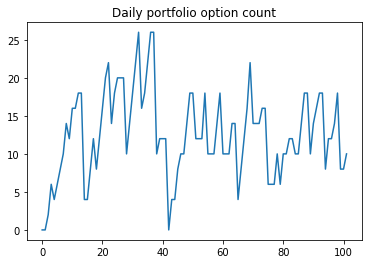

Elapsed time 3.75 seconds
Short strangle3


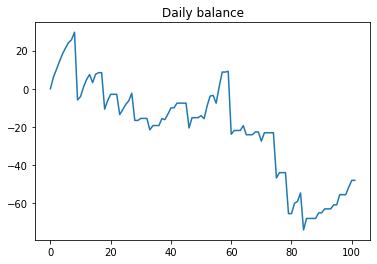

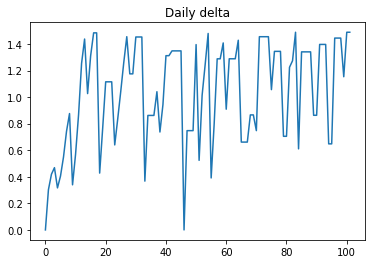

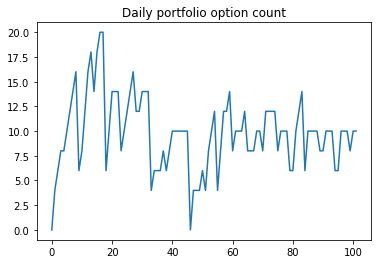

Elapsed time 6.5 seconds
Short straddle


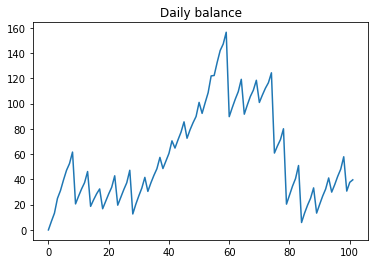

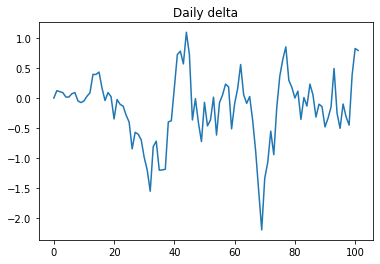

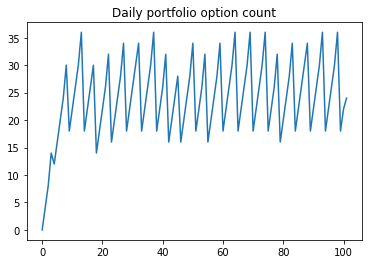

Elapsed time 2.328125 seconds


In [81]:
assets = ['AMZN', 'GOOGL', 'NFLX', 'MSFT', 'FB', 'BA']
#assets = ['AMZN']
for asset_name in assets:
    loader = cf.DataLoader(asset_name)
    loader.load()
    print(f"Simple simulation for {asset_name}")
    print("Short strangle")
    ShortStrangle(loader, asset_name).simulate()
    print("Short strangle2")
    ShortStrangle2(loader, asset_name).simulate()
    print("Short strangle3")
    ShortStrangle3(loader, asset_name).simulate()
    print("Short straddle")
    ShortStraddle(loader, asset_name).simulate()

